Let's do a simulation of two areas with E populations with simplified dynamics. We will only include the NMDA synapses for the E pop, a la Wong & Wang, 2006. 


In [1]:
# let's get what we need together
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as si
import brian2

Define the function that transforms input current to changes in firing rate (Abbott and Chance, 2005)
<br>
$$r_i = f(I_i) = \frac{aI_i - b}{1 - e^{-d(aI_i - b)}} $$

In [2]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_E']
        b = parameters['b_E']
        d = parameters['d_E']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    elif population_type == 'I':
        a = parameters['a_I']
        b = parameters['b_I']
        d = parameters['d_I']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
        
        # NOTE: using python broadcasting for ones subtraction, so should work for multi-area case too

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + (1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [3]:
def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gamma']*(1 - S_NMDA_prev)*rate_now

Set up local circuit parameters

In [4]:
pops = ['E1','E2']


# Set up connectivity matrix. Parameters based on García del Molino et al., eLife, 2017
# converted to match Recurrent vs cross population weight proportions from Wong & Wang, 2006

# Synaptic strengths from E cells
g_Eself   = 0.2609 * brian2.nA              
g_Ecross  = 0.0497 * brian2.nA                     

# put values into connectivity matrix
J = np.array([[g_Eself, -g_Ecross],
              [-g_Ecross  , g_Eself]]) * brian2.amp

row_labels = ['to E1', 'to E2']
column_labels = ['from E2', 'from E2']

df_all = pandas.DataFrame(J, columns=column_labels, index=row_labels)

local_params = {}
# population time constants
# Set units using Brian2
local_params['tau_NMDA'] = 100 * brian2.ms
local_params['tau_AMPA'] = 2 * brian2.ms

# f-I curve parameters, E - populations (Wong & Wang, 2006)
local_params['a_E'] = 0.27  * brian2.Hz / brian2.pA 
local_params['b_E'] = 108   * brian2.Hz
local_params['d_E'] = 0.154 * brian2.second

# gamma (Wong & Wang, 2006)
local_params['gamma'] = 0.641 

# external input parameters
J_A_ext = 0.52* brian2.pA / brian2.Hz
mu_0    = 30 * brian2.Hz
contrast = 0.0

# background inputs
I_0_strength = 0.3255 * brian2.nA

# # standard deviation of the noise (Wong & Wang, 2006). Default = 0.01
std_noise = 0.02 * brian2.nA

local_params['num_pops'] = 2

print(J_A_ext*mu_0)

15.6 pA


Set up for simulation

In [5]:
# Set up simulation parameters
dt=0.1 * brian2.ms  # timestep 
trial_length=3000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)

num_pops = local_params['num_pops']

# initial firing rate at zero
R0 = np.zeros((num_pops))
              
S_NMDA0 = 0.1*(np.ones((num_pops)))

# Preassign rate and synapse matrices

R = np.zeros((num_iterations,num_pops)) * brian2.Hz
S_NMDA = np.zeros((num_iterations,num_pops))

# Preassign external inputs
I_ext    = np.zeros((num_iterations,num_pops)) * brian2.pA
stim_on  = 0.5 #s
stim_off = 1 #s

# Let's apply external stimulation to populations E1 & E2
I_ext[int(stim_on/dt):int(stim_off/dt),0] = J_A_ext*mu_0*(1 + contrast)
I_ext[int(stim_on/dt):int(stim_off/dt),1] = J_A_ext*mu_0*(1 - contrast)

# Create matrices in which we can store the currents
I_local_NMDA =  np.zeros((num_iterations,num_pops)) * brian2.pA

I_total =  np.zeros((num_iterations,num_pops)) * brian2.pA

# # Define background inputs
I_0 = I_0_strength*np.ones((num_pops))

# Define currents dictionary
currents = {}
currents["I_ext"]         = I_ext
currents["I_0"]           = I_0
currents["I_local_NMDA"]  = I_local_NMDA 

# Initial values
R[0,:] = R0 * brian2.Hz
S_NMDA[0,:] = S_NMDA0

# # Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.

# # Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations, local_params['num_pops'] ))

# # prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(local_params['tau_AMPA']*np.power(std_noise,2))*np.sqrt(dt))/local_params['tau_AMPA'])

# # # initialise noise to zero
I_noise = np.zeros((local_params['num_pops'] )) * brian2.nA

print(noise_rhs)

[[-5.30081552 -2.53449117]
 [ 2.26056451 -2.19292445]
 [ 8.63211259  0.48616002]
 ..., 
 [ 0.42321019  5.50456199]
 [ 9.56568747  0.03027388]
 [ 0.73571865  1.98677992]] pA


Let's run the simulation

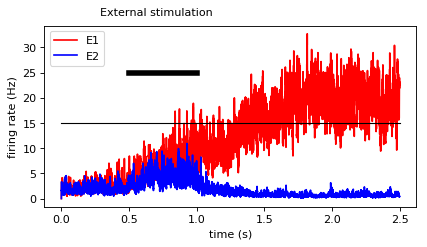

In [6]:
for i_t in range(1,num_iterations):
    
    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/local_params['tau_AMPA']) + noise_rhs[i_t-1,:]
    
    # sum up all the local NMDA current
    # Note, we're using python broadcasting to implement the gradient. If replicating in Matlab, will need to use repmat
    I_local_NMDA[i_t-1,:] = J.dot(S_NMDA[i_t-1,:].T).T

    # Define total input current as sum of local NMDA, AMPA & GABA inputs, with background and external currents, noise and long-range NMDA and AMPA inputs
    I_total[i_t-1,:] = I_local_NMDA[i_t-1,:] + I_0 + I_ext[i_t-1,:] + I_noise  
    
    # Update the firing rates of the two excitatory populations. Assuming instantaneous update (tau_R = 0)
    R[i_t,:] = current_to_frequency(I_total[i_t-1,:],'E',local_params)
    
    # Update the NMDA synapses
    S_NMDA[i_t,:] = S_NMDA[i_t-1,:] + dt*NMDA_deriv(S_NMDA[i_t-1,:],R[i_t,:],local_params)
    
fig=plt.figure(figsize=(6,3), dpi= 80, facecolor='w', edgecolor='k')

start_time = 0 #seconds
end_time = 2.5 #seconds


plt.plot(np.arange(start_time*brian2.second,end_time*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),0], color='r')
plt.plot(np.arange(start_time*brian2.second,end_time*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),1], color='b')


plt.legend(['E1','E2'])
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
    
# Plot the stimulation time
plt.plot([stim_on,stim_off],[25,25],color='black',linewidth=5.0)

# Plot the threshold line
plt.plot([start_time,end_time],[15,15],color='black',linewidth=1.0)

# place text above the black line
axes = plt.gca()
axes.text(0.15, 1.1,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')


Plot the currents

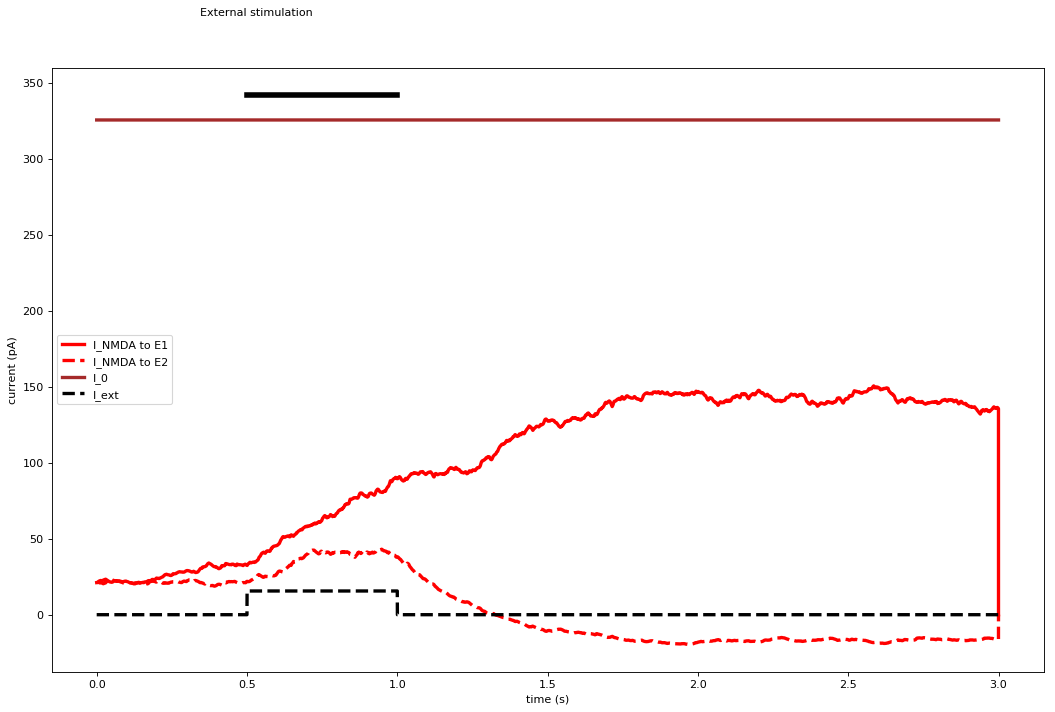

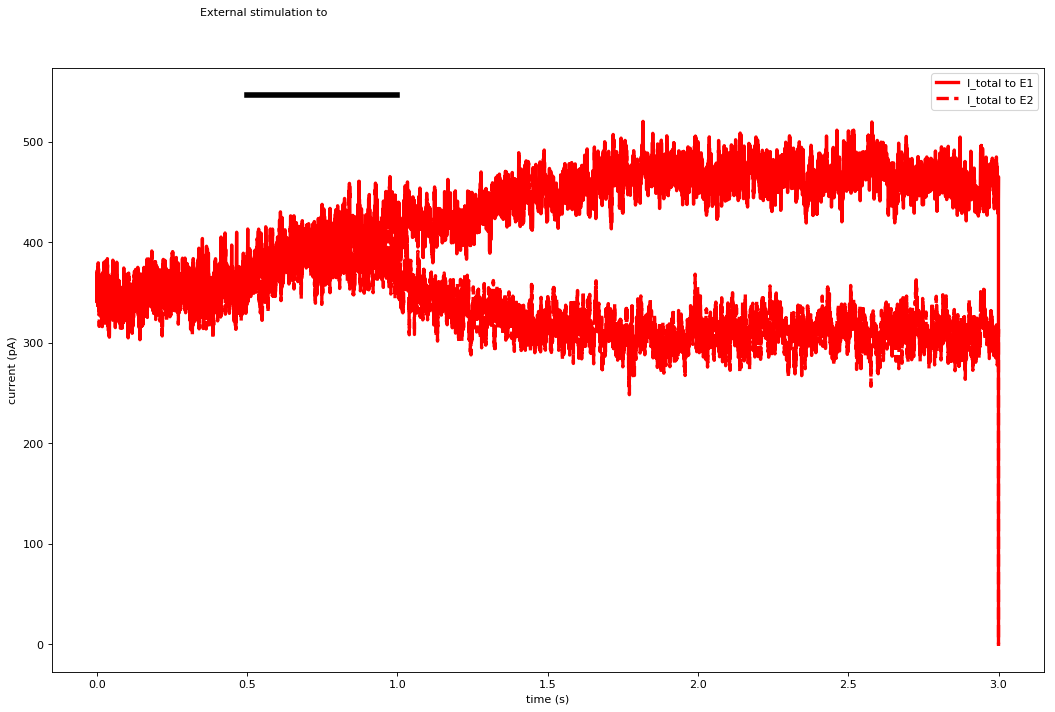

In [7]:
I_0_mat = np.matlib.repmat(I_0,num_iterations,1)

fig=plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='k')

# Plot the local NMDA currents onto both populations
plt.plot(np.arange(0,trial_length,dt),1e12*I_local_NMDA[np.arange(0,int(num_iterations)),0],linestyle='-', color='r', linewidth=3)
plt.plot(np.arange(0,trial_length,dt),1e12*I_local_NMDA[np.arange(0,int(num_iterations)),1],linestyle='--', color='r', linewidth=3)

#plot the background current (same onto both E and I pops)
plt.plot(np.arange(0,trial_length,dt),1e12*I_0_mat[np.arange(0,int(num_iterations)),1],linestyle='-', color='brown', linewidth=3)

#plot the external current onto E pop only
plt.plot(np.arange(0,trial_length,dt),1e12*I_ext[np.arange(0,int(num_iterations)),0],linestyle='--', color='k', linewidth=3)

# Plot the stimulation time
plt.plot([stim_on,stim_off],[1e12*(I_0[0]+0.05*I_0[0]),1e12*(I_0[0]+0.05*I_0[0])],color='black',linewidth=5.0)
# place text above the black line
axes = plt.gca()
axes.text(0.15, 1.1,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

plt.legend(['I_NMDA to E1','I_NMDA to E2',  'I_0', 'I_ext'])
plt.xlabel('time (s)')
plt.ylabel('current (pA)')

fig=plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='k')

# Plot the rates for the first excitatory population 

# Plot the total currents onto both populations
plt.plot(np.arange(0,trial_length,dt),1e12*I_total[np.arange(0,int(num_iterations)),0],linestyle='-', color='r', linewidth=3)
plt.plot(np.arange(0,trial_length,dt),1e12*I_total[np.arange(0,int(num_iterations)),1],linestyle='--', color='r', linewidth=3)


# Plot the stimulation time
plt.plot([stim_on,stim_off],[1e12*(np.max(I_total[:,0]+0.05*np.max(I_total[:,0]))),1e12*(np.max(I_total[:,0]+0.05*np.max(I_total[:,0])))],color='black',linewidth=5.0)
# place text above the black line
axes = plt.gca()
axes.text(0.15, 1.1,'External stimulation to', transform=axes.transAxes, fontsize=10, verticalalignment='top')

plt.legend(['I_total to E1','I_total to E2'])
plt.xlabel('time (s)')
plt.ylabel('current (pA)')
    

Let's set up for the phase portrait

In [8]:
import PyDSTool as dst

Let's do the phase portrait for the case with no stimulus

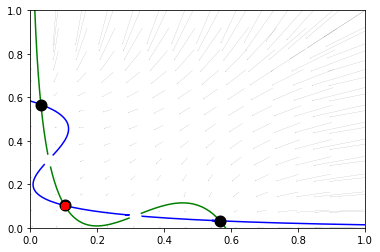

In [9]:
# we must give a name
DSargs = dst.args(name='Wong-Wang_no_stim')

# parameters
DSargs.pars = { 'tau_NMDA': 0.1,
                'a_E': 270.,
                'b_E': 108.,
                'd_E': 0.154,
                'gam': 0.641,
                'g_Eself': 0.2609,
                'g_Ecross': 0.0497,
                'I_0': 0.3255,
                'I_ext': 0}

# auxiliary functions: fI curve and recurrent current
DSargs.fnspecs  = {
    'fI_E': (['I'], '(a_E*I-b_E)/(1.0 - exp(-d_E*(a_E*I-b_E)))'),
    'recCurrE': (['x', 'y'], 'g_Eself*x - g_Ecross*y + I_0')
}

# rhs of the differential equations
DSargs.varspecs = {'S_E1': '(-S_E1/tau_NMDA + gam*(1.0 - S_E1)*fI_E(recCurrE(S_E1,S_E2) + I_ext))',
                   'S_E2': '(-S_E2/tau_NMDA + gam*(1.0 - S_E2)*fI_E(recCurrE(S_E2,S_E1) + I_ext))'}

# initial conditions
DSargs.ics = {'S_E1': 0.1, 'S_E2': 0.1}

# set the range of integration
DSargs.tdomain = [0,3]

# variable domain for the phase plane analysis
DSargs.xdomain = {'S_E2': [0,1], 'S_E1': [0,1]}

# variable domain for the phase plane analysis
DSargs.pdomain = {'I_ext': [0,0.3] }

# Create the model object
dmModel = dst.Vode_ODEsystem(DSargs)

# Open a figure and plot the vector field
from PyDSTool.Toolbox import phaseplane as pp

pp.plot_PP_vf(dmModel,'S_E2','S_E1',N=14, scale_exp=-1)

# Find the fixed points
fp_coord = pp.find_fixedpoints(dmModel,n=6,eps=1e-8)

# Find and plot the nullclines
nulls_x, nulls_y = pp.find_nullclines(dmModel, 'S_E1', 'S_E2', n=3, eps=1e-8,max_step=0.01,fps=fp_coord)

plt.plot(nulls_x[:,1], nulls_x[:,0],'b')
plt.plot(nulls_y[:,1], nulls_y[:,0],'g')

# Compute the jacobian to determine the stability of the fixed points
jac, new_fnspecs = \
dst.prepJacobian(dmModel.funcspec._initargs['varspecs'],
['S_E2', 'S_E1'], dmModel.funcspec._initargs['fnspecs'])
scope = dst.copy(dmModel.pars)
scope.update(new_fnspecs)
jac_fn = dst.expr2fun(jac, ensure_args=['t'], **scope)

# add fixed points to the phase portrait

for i in range(0,len(fp_coord)):
    fp = pp.fixedpoint_2D(dmModel,dst.Point(fp_coord[i]),
                         jac = jac_fn, eps=1e-8)
    pp.plot_PP_fps(fp)
    
# compute an example trajectory
traj = dmModel.compute('trajectory1')
pts = traj.sample()
plt.plot(pts['S_E2'],pts['S_E1'],'r-o')

Let's do the phase portrait for the case with a 0% coherent stimulus

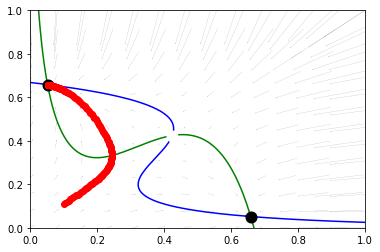

In [10]:
# we must give a name
DSargs = dst.args(name='Wong-Wang_zerocoherence_stim')

# parameters
DSargs.pars = { 'tau_NMDA': 0.1,
                'a_E': 270.,
                'b_E': 108.,
                'd_E': 0.154,
                'gam': 0.641,
                'g_Eself': 0.2609,
                'g_Ecross': 0.0497,
                'I_0': 0.3255,
                'I_ext': 0.0156}

# auxiliary functions: fI curve and recurrent current
DSargs.fnspecs  = {
    'fI_E': (['I'], '(a_E*I-b_E)/(1.0 - exp(-d_E*(a_E*I-b_E)))'),
    'recCurrE': (['x', 'y'], 'g_Eself*x - g_Ecross*y + I_0')
}

# rhs of the differential equations
DSargs.varspecs = {'S_E1': '(-S_E1/tau_NMDA + gam*(1.0 - S_E1)*fI_E(recCurrE(S_E1,S_E2) + I_ext))',
                   'S_E2': '(-S_E2/tau_NMDA + gam*(1.0 - S_E2)*fI_E(recCurrE(S_E2,S_E1) + I_ext))'}

# initial conditions
DSargs.ics = {'S_E1': 0.11, 'S_E2': 0.1}

# set the range of integration
DSargs.tdomain = [0,3]

# variable domain for the phase plane analysis
DSargs.xdomain = {'S_E2': [0,1], 'S_E1': [0,1]}

# variable domain for the phase plane analysis
DSargs.pdomain = {'I_ext': [0,0.3] }

# Create the model object
dmModel = dst.Vode_ODEsystem(DSargs)

# Open a figure and plot the vector field
from PyDSTool.Toolbox import phaseplane as pp

pp.plot_PP_vf(dmModel,'S_E2','S_E1',N=14, scale_exp=-1)

# Find the fixed points
fp_coord = pp.find_fixedpoints(dmModel,n=6,eps=1e-8)

# Find and plot the nullclines
nulls_x, nulls_y = pp.find_nullclines(dmModel, 'S_E1', 'S_E2', n=3, eps=1e-8,max_step=0.01,fps=fp_coord)

plt.plot(nulls_x[:,1], nulls_x[:,0],'b')
plt.plot(nulls_y[:,1], nulls_y[:,0],'g')

# Compute the jacobian to determine the stability of the fixed points
jac, new_fnspecs = \
dst.prepJacobian(dmModel.funcspec._initargs['varspecs'],
['S_E2', 'S_E1'], dmModel.funcspec._initargs['fnspecs'])
scope = dst.copy(dmModel.pars)
scope.update(new_fnspecs)
jac_fn = dst.expr2fun(jac, ensure_args=['t'], **scope)

# add fixed points to the phase portrait

for i in range(0,len(fp_coord)):
    fp = pp.fixedpoint_2D(dmModel,dst.Point(fp_coord[i]),
                         jac = jac_fn, eps=1e-8)
    pp.plot_PP_fps(fp)
    
# compute an example trajectory
traj = dmModel.compute('trajectory1')
pts = traj.sample()
plt.plot(pts['S_E2'],pts['S_E1'],'r-o')